In [1]:
from cryoS2Sdrop.analyze import *

PARENT_PATH = setup.PARENT_PATH

pd.options.display.float_format = "{:,.6f}".format
pd.set_option('display.max_columns', 50)

%matplotlib inline
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

# Structured noise

In [3]:
tomo_list = [
    'tomoPhantom_model8_noisyGaussPoissVL_Perlin',
    'tomoPhantom_model14_noisyGaussPoissVL_Perlin',
    'tomoPhantom_model16_noisyGaussPoissVL_Perlin'
]
exp_name = "structuredNoise_comparison"

data_log = []

for tomo in tomo_list:
        
    logdir = 'data/S2SDenoising/model_logs/%s/%s/' %(tomo, exp_name)
    logdir = os.path.join(PARENT_PATH, logdir)

    _data_log = logdir_to_dataframe(logdir, clip_values=True)
    data_log.append(_data_log)

data_log = pd.concat(data_log)
data_log = data_log.reset_index().drop('index', 1)
data_log.head()

,model,version,dataset,TV_alpha,Version_comment,transform,full_tomo_psnr,full_tomo_ssim,baseline_psnr,baseline_ssim,tomo_path,gt_tomo_path,use_deconv_as_target,predict_simRecon,use_deconv_data,p,n2v_psnr,n2v_ssim,baseline_psnr_best,baseline_ssim_best,ssim_vs_baseline,n2v_ssim_vs_baseline,psnr_vs_baseline,n2v_psnr_vs_baseline,noise_level,tomo_name,pred_path
0,structuredNoise_comparison,version_0,singleCET_FourierDataset,0,"p0.1, Vmask_p0.5, volFact8, dropout0.7",{'p': '0.5'},11.190657,0.096147,7.279469,0.034949,/home/ubuntu/Thesis/data/S2SDenoising/dummy_to...,/home/ubuntu/Thesis/data/S2SDenoising/dummy_to...,None,None,false,0.7,None,None,7.279469,0.034949,175.109047,NaN,53.729014,NaN,Gauss(0.2) + Poisson + Perlin,blobs,/home/ubuntu/Thesis/data/S2SDenoising/model_lo...
1,structuredNoise_comparison,version_1,singleCET_dataset,0,"VolMask(0.5), p=0.5, dropout_p=0.5, Vmask_prob=0",{'p': '0.5'},9.537925,0.087631,7.279469,0.034949,/home/ubuntu/Thesis/data/S2SDenoising/dummy_to...,/home/ubuntu/Thesis/data/S2SDenoising/dummy_to...,None,None,false,0.5,None,None,7.279469,0.034949,150.742308,NaN,31.024998,NaN,Gauss(0.2) + Poisson + Perlin,blobs,/home/ubuntu/Thesis/data/S2SDenoising/model_lo...
2,structuredNoise_comparison,version_0,singleCET_FourierDataset,0,"p0.1, Vmask_p0.5, volFact8, dropout0.7",{'p': '0.5'},13.763026,0.354847,11.725995,0.054281,/home/ubuntu/Thesis/data/S2SDenoising/dummy_to...,/home/ubuntu/Thesis/data/S2SDenoising/dummy_to...,None,None,false,0.7,None,None,11.725995,0.054281,553.717507,NaN,17.371926,NaN,Gauss(0.2) + Poisson + Perlin,cell,/home/ubuntu/Thesis/data/S2SDenoising/model_lo...
3,structuredNoise_comparison,version_1,singleCET_dataset,0,"VolMask(0.5), p=0.5, dropout_p=0.5, Vmask_prob=0",{'p': '0.5'},14.202926,0.357794,11.725995,0.054281,/home/ubuntu/Thesis/data/S2SDenoising/dummy_to...,/home/ubuntu/Thesis/data/S2SDenoising/dummy_to...,None,None,false,0.5,None,None,11.725995,0.054281,559.146458,NaN,21.123415,NaN,Gauss(0.2) + Poisson + Perlin,cell,/home/ubuntu/Thesis/data/S2SDenoising/model_lo...
4,structuredNoise_comparison,version_0,singleCET_FourierDataset,0,"p0.1, Vmask_p0.5, volFact8, dropout0.7",{'p': '0.5'},11.572007,0.325215,8.768543,0.063508,/home/ubuntu/Thesis/data/S2SDenoising/dummy_to...,/home/ubuntu/Thesis/data/S2SDenoising/dummy_to...,None,None,false,0.7,None,None,8.768543,0.063508,412.088146,NaN,31.971832,NaN,Gauss(0.2) + Poisson + Perlin,spaceship,/home/ubuntu/Thesis/data/S2SDenoising/model_lo...


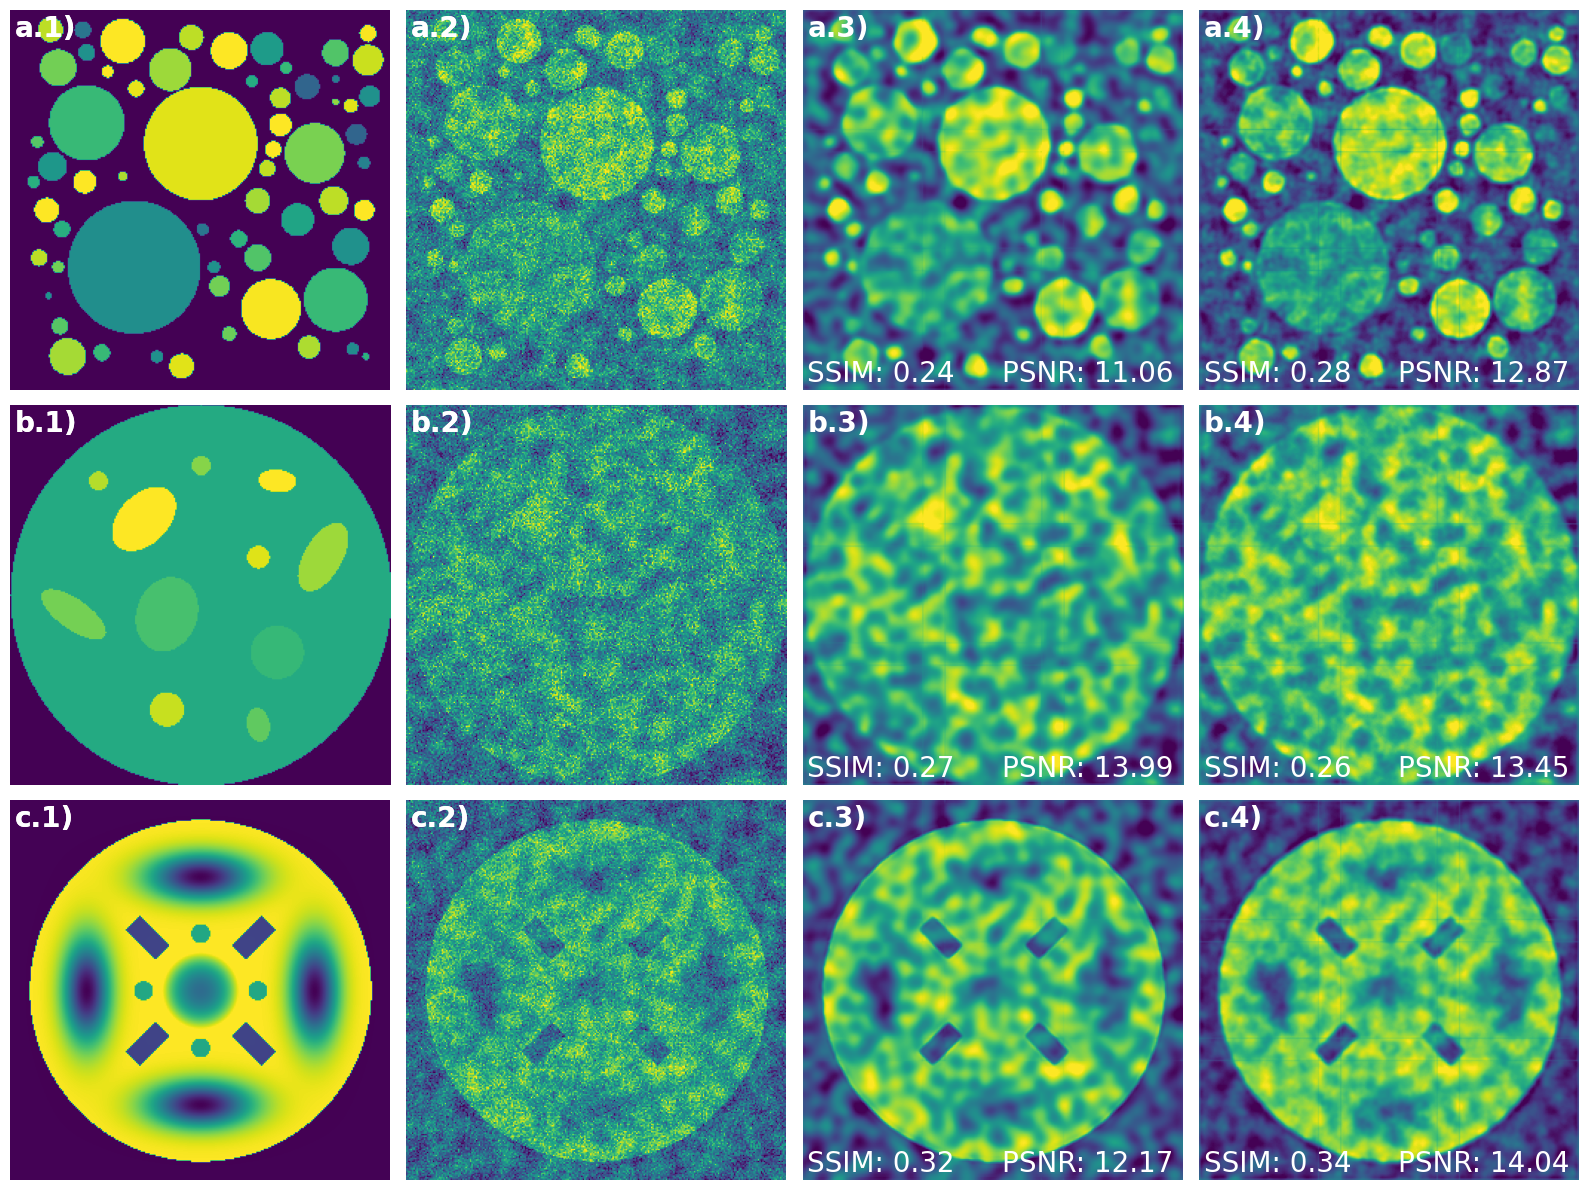

In [49]:
idx = data_log.groupby(['tomo_name', 'version'])['full_tomo_ssim'].transform(max) == data_log['full_tomo_ssim']

df = data_log[idx].reset_index()

# display(df)

fig, ax = plt.subplots(3, 4, figsize=(16, 12), dpi=100)
list(map(lambda axi: axi.set_axis_off(), ax.ravel()))
plt.tight_layout()

for group_idx, g in enumerate(df.groupby('tomo_name')):
    group = g[1]
    current_ax = ax[group_idx]
    row_letter = string.ascii_lowercase[group_idx]
    for i, row in group.iterrows():
        # read data
        gt = read_array(row.gt_tomo_path)
        gt = standardize(clip(gt))
        gt = scale(gt)
        noisy = read_array(row.tomo_path)
        noisy = standardize(clip(noisy))
        noisy = scale(noisy)
        denoised = read_array(row.pred_path)
        denoised = standardize(clip(denoised))
        denoised = scale(denoised)
    
        zidx = len(gt)//2
        
        # parse axes
        ax_gt = current_ax[0]
        ax_noisy = current_ax[1]
        if row.dataset == 'singleCET_dataset ':
            ax_denoised = current_ax[2]
            col_num = 3
        elif row.dataset == 'singleCET_FourierDataset ':
            ax_denoised = current_ax[3]
            col_num = 4
        
        # plot data
        ax_gt.imshow(gt[zidx], vmin=0, vmax=1)
            
        _ssim = ssim(torch.tensor(gt[zidx]).unsqueeze(0).unsqueeze(0),
                     torch.tensor(noisy[zidx]).unsqueeze(0).unsqueeze(0), 
                     data_range=1)
    
        _psnr = peak_signal_noise_ratio(torch.tensor(gt[zidx]).unsqueeze(0).unsqueeze(0),
                     torch.tensor(noisy[zidx]).unsqueeze(0).unsqueeze(0), 
                     data_range=1)

        ax_noisy.text(0.0125, 0.02, 'SSIM: %.02f' %float(_ssim), transform=ax_noisy.transAxes, size=20, color='white')
        ax_noisy.text(0.5+0.125, 0.02, 'PSNR: %.02f' %float(_psnr), transform=ax_noisy.transAxes, size=20, color='white')

        ax_noisy.imshow(noisy[zidx], vmin=0, vmax=1)
        ax_denoised.imshow(denoised[zidx], vmin=0, vmax=1)
        
        _ssim = ssim(torch.tensor(gt[zidx]).unsqueeze(0).unsqueeze(0),
                     torch.tensor(denoised[zidx]).unsqueeze(0).unsqueeze(0), 
                     data_range=1)

        _psnr = peak_signal_noise_ratio(torch.tensor(gt[zidx]).unsqueeze(0).unsqueeze(0),
                     torch.tensor(denoised[zidx]).unsqueeze(0).unsqueeze(0), 
                     data_range=1)
        # legends
        ax_gt.text(0.0125, 0.93, '%s.%i)'%(row_letter, 1), transform=ax_gt.transAxes, size=20, weight='bold', color='white')
        ax_noisy.text(0.0125, 0.93, '%s.%i)'%(row_letter, 2), transform=ax_noisy.transAxes, size=20, weight='bold', color='white')
        ax_denoised.text(0.0125, 0.93, '%s.%i)'%(row_letter, col_num), transform=ax_denoised.transAxes, size=20, weight='bold', color='white')
        
        ax_denoised.text(0.0125, 0.02, 'SSIM: %.02f' %float(_ssim), transform=ax_denoised.transAxes, size=20, color='white')
        ax_denoised.text(0.5+2*0.0125, 0.02, 'PSNR: %.02f' %float(_psnr), transform=ax_denoised.transAxes, size=20, color='white')

array([['version_0', 'p0.1, Vmask_p0.5, volFact8, dropout0.7'],
       ['version_1', 'VolMask(0.5), p=0.5, dropout_p=0.5, Vmask_prob=0'],
       ['version_0', 'p0.1, Vmask_p0.5, volFact8, dropout0.7'],
       ['version_1', 'VolMask(0.5), p=0.5, dropout_p=0.5, Vmask_prob=0'],
       ['version_0', 'p0.1, Vmask_p0.5, volFact8, dropout0.7'],
       ['version_1', 'VolMask(0.5), p=0.5, dropout_p=0.5, Vmask_prob=0']],
      dtype=object)

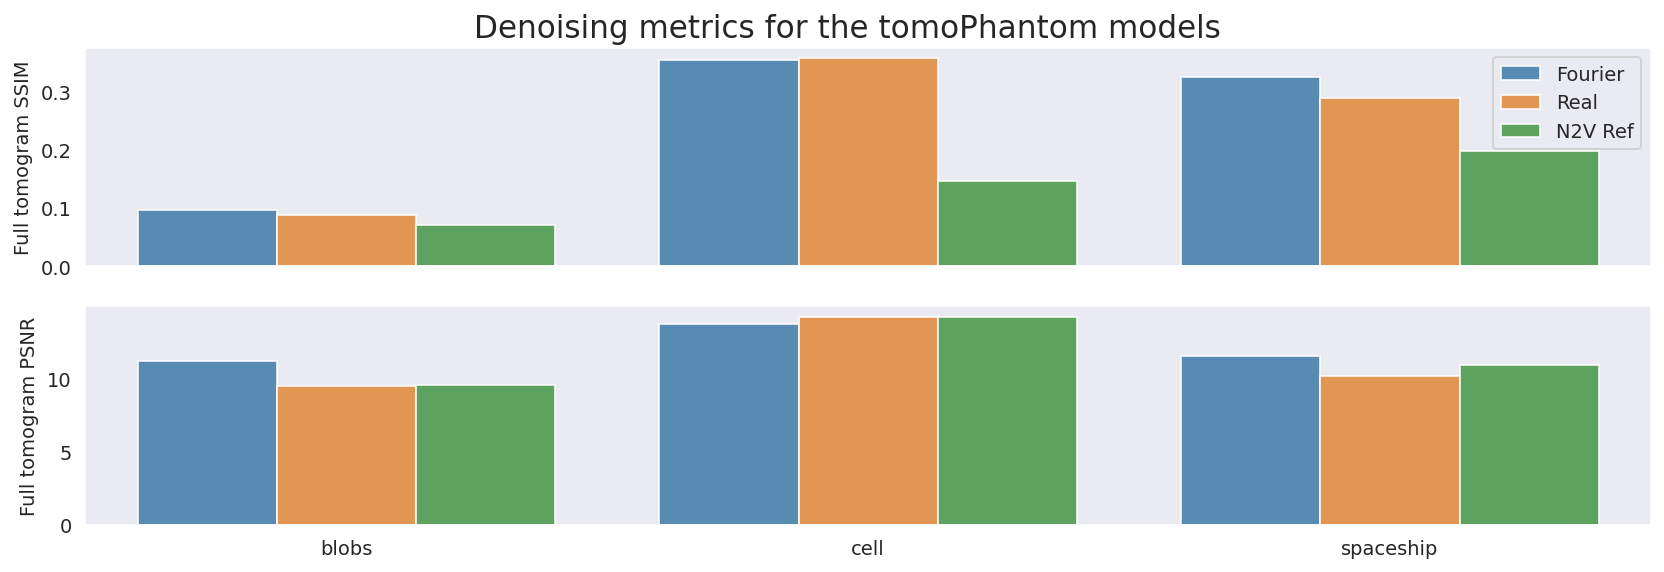

In [51]:
y_cols = ["full_tomo_ssim", "full_tomo_psnr"]
x_col = "tomo_name"
hue_col = "version"

df = data_log.groupby([x_col, hue_col])[y_cols].mean().reset_index()

df2 = data_log.groupby([x_col])['n2v_ssim', 'n2v_psnr'].mean().reset_index()
df2[hue_col] = 'N2V Ref'
df2 = df2[[x_col, hue_col, 'n2v_ssim', 'n2v_psnr']]

df2.columns = [x_col, hue_col] + y_cols

df = pd.concat([df, df2])
df['version'] = df.version.map(lambda x: 'Fourier' if x=='version_0' else ('Real' if x=='version_1' else x))

fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(12, 4), sharex=True, dpi=140)

plt.tight_layout()
name = data_log.gt_tomo_path.unique()[0].split('/')[-1].replace('.mrc', '')

display(data_log[["version", "Version_comment"]].values)

if name == 'tomoPhantom_model14':
    name = '"cell" model'
if name == 'tomoPhantom_model16':
    name = '"spaceship" model'
if name == 'tomoPhantom_model8':
    name = '"blobs" model'
    
plt.suptitle('Denoising metrics for the tomoPhantom models', y=1.01)

sns.barplot(data=df, hue=hue_col, y=y_cols[0], x=x_col, ax=ax0, alpha=0.8)
ax0.set_xlabel('')
sns.barplot(data=df, hue=hue_col, y=y_cols[1], x=x_col, ax=ax1, alpha=0.8)
ax1.set_xlabel(x_col)
ax1.set_xlabel('')

ax0.set_ylabel('Full tomogram SSIM', fontsize=10)
ax1.set_ylabel('Full tomogram PSNR', fontsize=10)
ax0.legend(bbox_to_anchor=(1, 1))
ax1.get_legend().remove()